# Linear Assignment Problem

In [1]:
# !pip install ipdb
# !pip install napari

In [2]:
# Force keras to run on CPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import ipdb

# Notebook at full width in the browser
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
from urllib.request import urlretrieve
from pathlib import Path
from collections import defaultdict
from abc import ABC, abstractmethod

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams["image.interpolation"] = "none"
matplotlib.rcParams['figure.figsize'] = (14, 10)
import numpy as np
from tifffile import imread, imwrite
from tqdm.auto import tqdm
import skimage
import pandas as pd
import scipy
import pathlib
import networkx
import pathlib
from tifffile import imread, imwrite
import tensorboard

import napari

# Pretty tqdm progress bars 
! jupyter nbextension enable --py widgetsnbextension

/home/bourquea/miniconda3/envs/celltracking/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Traceback (most recent call last):
  File "/home/bourquea/miniconda3/envs/celltracking/bin/jupyter-nbextension", line 10, in <module>
    sys.exit(main())
  File "/home/bourquea/miniconda3/envs/celltracking/lib/python3.9/site-packages/jupyter_core/application.py", line 269, in launch_instance
    return super().launch_instance(argv=argv, **kwargs)
  File "/home/bourquea/miniconda3/envs/celltracking/lib/python3.9/site-packages/traitlets/config/application.py", line 976, in launch_instance
    app.start()
  File "/home/bourquea/miniconda3/envs/celltracking/lib/python3.9/site-packages/nbclassic/nbextensions.py", line 972, in start
    super().start()
  File "/home/bourquea/miniconda3/envs/celltracking/lib/python3.9/site-packages/jupyter_core/application.py", line 258, in start
    self.subapp.start()
  File "/home/bourquea/miniconda3/envs/celltracking/lib/python3.9/site-packages/nbclassic/nbextensions.py", line 882, in start
    self.toggle_nbextension_python(self.extra_args[0])
  File "/

# Calculate Euclidean Distances

## Calculate Centroids

In [3]:
# function to convert 'TRA' channel into cell and frame-wise centroid positions
## Function to extract trajectories from data

base_path = pathlib.Path("/mnt/shared/celltracking/data/cho/")

# read parent-child links from file
links = np.loadtxt(base_path / "01_GT/TRA" / "man_track.txt", dtype=int)

# read annotated image stack
centroids = np.stack([imread(xi) for xi in sorted((base_path / "01_GT/TRA").glob("*.tif"))])  # images

pts = []
# extract centroids from annotated image stacks

# for img in range(len(centroids))
#     blobs = skimage.measure.regionprops(centroids[img,0,:,:])
#     for blob in blobs:
#         y0, x0 = blob.centroid
#         pts.append((x0, y0))

In [4]:
# function to convert 'TRA' channel into cell and frame-wise centroid positions
## Function to extract trajectories from data

base_path = pathlib.Path("/mnt/shared/celltracking/data/cho/")

# read parent-child links from file
links = np.loadtxt(base_path / "01_GT/TRA" / "man_track.txt", dtype=int)

# read annotated image stack
centroids = np.stack([imread(xi) for xi in sorted((base_path / "01_GT/TRA").glob("*.tif"))])  # images

# extract centroids from annotated image stacks
centers = skimage.measure.regionprops(centroids[0,0,:,:])
tracks = []
centroid_info = []
cntrs = []
for t, frame in enumerate(centroids):
    centers = skimage.measure.regionprops(frame)
    temp = []
    for c in centers:
        tracks.append([c.label, t, int(c.centroid[1]), int(c.centroid[2])])
        centroid_info.append([c.label, t, int(c.centroid[1]), int(c.centroid[2])])
        temp.append([int(c.centroid[1]), int(c.centroid[2])])
    
    cntrs.append(temp)
        
# constructs graph 
tracks = np.array(tracks)
graph = networkx.DiGraph()
for cell_id, t, x, y in tracks:
    graph.add_node((cell_id,t), x=x, y=y, t=t)
    
for cell_id, t in graph.nodes():
    if (cell_id, t+1) in graph.nodes():
        graph.add_edge((cell_id, t), (cell_id,t+1))

for child_id, child_from, _, child_parent_id in links:
    for parent_id, _, parent_to, _ in links:
        if child_parent_id == parent_id:
            graph.add_edge((parent_id, parent_to), (child_id, child_from))
            
# extract trajectories from graph set
tracks = [graph.subgraph(c) for c in networkx.weakly_connected_components(graph) if len(c)>0]

# remove tracks with 0 edges
tracks = [track for track in tracks if len(track.edges)>0]

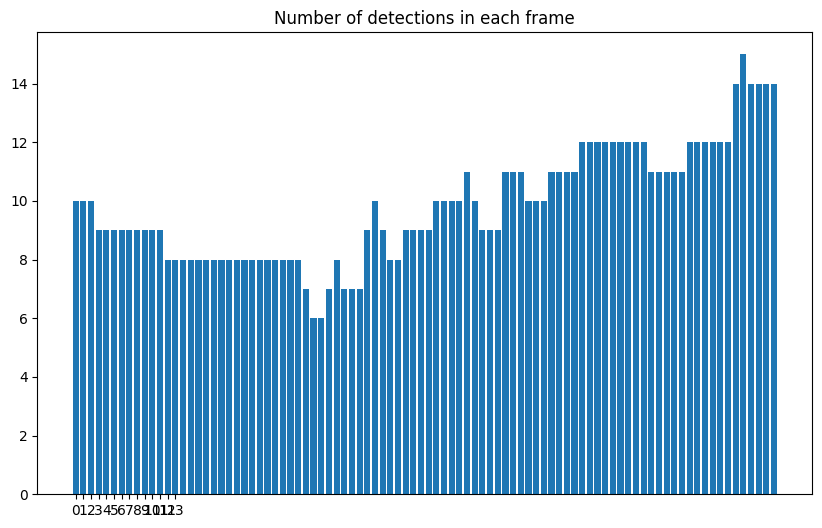

In [5]:
plt.figure(figsize=(10,6))
plt.bar(range(len(cntrs)), [len(xi) for xi in cntrs])
plt.title(f"Number of detections in each frame")
plt.xticks(range(len(centers)))
plt.show();

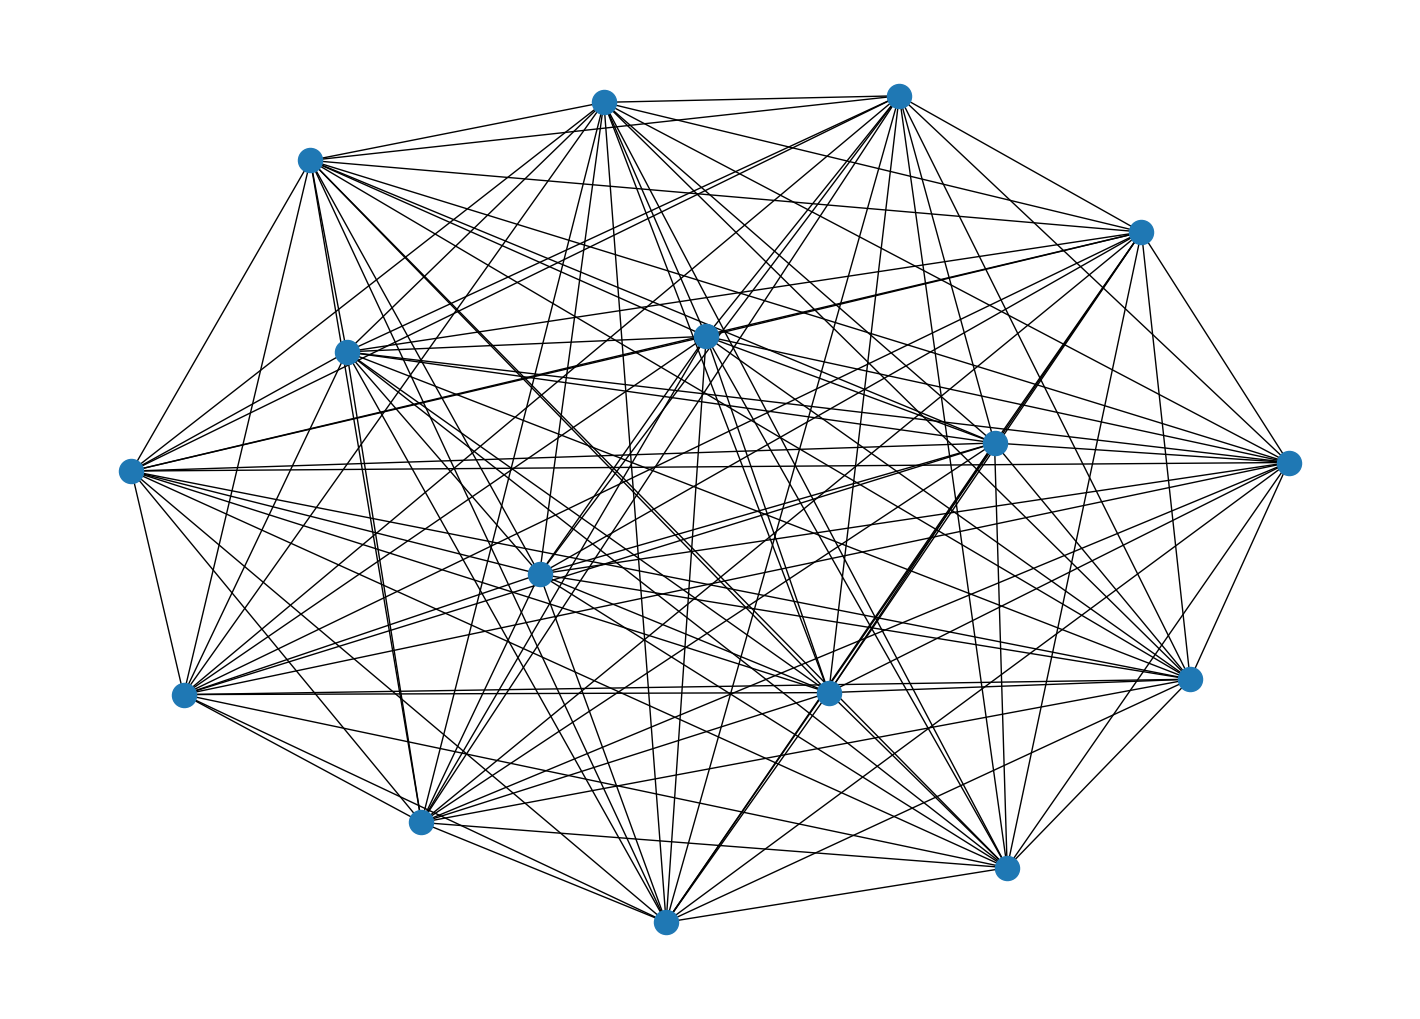

In [6]:
G = networkx.complete_graph(tracks)
networkx.draw_spring(G)

# Euc Distance Function

In [7]:
# Solution Exercise 1.3
def pairwise_euclidian_distance(points0, points1):
    #print("Iterative pairwise euclidian distance")
    dists = []
    for p0 in points0:
        for p1 in points1:
            dists.append(np.sqrt(((p0 - p1)**2).sum()))
            
    dists = np.array(dists).reshape(len(points0), len(points1))
    return dists

## Testing function

In [8]:
# p0 = np.array(cntrs[0]);
# p1 = np.array(cntrs[1]);

# dists = pairwise_euclidian_distance(p0, p1)

Optimal frame-by-frame matching (Linear assignment problem or Weighted bipartite matching)
The nearest neighbor algorithm above will not pick the best solution in many cases. For example, it does not consider the local arrangement of a few detections to create links, something which the human visual system is very good at.

We need a better optimization algorithm to minimize the total minimal linking distance between two frames. To use a classic and efficient optimization algorithm, we will represent this linking problem as a bipartite graph. Here is an example:

In [67]:
class FrameByFrameLinker(ABC):
    """Abstract base class for linking detections by considering pairs of adjacent frames."""
    
    def link(self, detections, images=None):
        """Links detections in t frames.
        
        Args:
        
            detections:
            
                List of t numpy arrays of shape (x,y) with contiguous label ids. Background = 0.
                
            images (optional):
            
                List of t numpy arrays of shape (x,y).
        
        Returns:
        
            Linking dictionary:
                "links":
                    
                    Tuple of lists. Links from frame t to frame t+1 of form (from0, to0) are split up into two lists: 
                    - idgs_from: [from0, from1 , ...])
                    - ids_to: [to0, to1 , ...])
                
                "births": List of ids from frame t that are 
                "deaths": List of ids.
            Ids are one-based, 0 is reserved for background.
        """
        if images is not None:
            assert len(images) == len(detections)
        else:
            images = [None] * len(detections)

        links = []
        for i in tqdm(range(len(images) - 1), desc="Linking"):
            detections0 = detections[i]
            detections1 = detections[i+1]
            self._assert_relabeled(detections0)
            self._assert_relabeled(detections1)
            
            cost_matrix = self.linking_cost_function(detections0, detections1, images[i], images[i+1])
            li = self._link_two_frames(cost_matrix)
            self._assert_links(links=li, time=i, detections0=detections0, detections1=detections1) 
            links.append(li)
            
        return links

    @abstractmethod
    def linking_cost_function(self, detections0, detections1, image0=None, image1=None):
        """Calculate features for each detection and extract pairwise costs.
        
        To be overwritten in subclass.
        
        Args:
        
            detections0: image with background 0 and detections 1, ..., m
            detections1: image with backgruond 0 and detections 1, ..., n
            image0 (optional): image corresponding to detections0
            image1 (optional): image corresponding to detections1
            
        Returns:
        
            m x n cost matrix 
        """
        pass
    
    @abstractmethod
    def _link_two_frames(self, cost_matrix):
        """Link two frames.
        
        To be overwritten in subclass.

        Args:

            cost_matrix: m x n matrix

        Returns:
        
            "links":

                Tuple of lists. Links from frame t to frame t+1 of form (from0, to0) are split up into two lists: 
                - idgs_from: [from0, from1 , ...])
                - ids_to: [to0, to1 , ...])

            "births": List of ids from frame t that are 
            "deaths": List of ids.
            
            Ids are one-based, 0 is reserved for background.
        """
        pass

    def relabel_detections(self, detections, links):
        """Relabel dense detections according to computed links, births and deaths.
        
        Args:
        
            detections: 
                 
                 List of t numpy arrays of shape (x,y) with contiguous label ids. Background = 0.
                 
            links:
                
                List of t linking dictionaries, each containing:
                    "links": Tuple of lists (ids frame t, ids frame t+1),
                    "births": List of ids,
                    "deaths": List of ids.
                Ids are one-based, 0 is reserved for background.
        """
        detections = detections.copy()
        
        assert len(detections) - 1 == len(links)
        # self._assert_relabeled(detections[0])
        out = [detections[0]]
        n_tracks = out[0].max()
        lookup_tables = [{i: i for i in range(1, out[0].max() + 1)}]

        for i in tqdm(range(len(links)), desc="Recoloring detections"):
            (ids_from, ids_to) = links[i]["links"]
            births = links[i]["births"]
            deaths = links[i+1]["deaths"] if i+1 < len(links) else []
            new_frame = np.zeros_like(detections[i+1])
            # self._assert_relabeled(detections[i+1])
            
            lut = {}
            for _from, _to in zip(ids_from, ids_to):
                # Copy over ID
                #ipdb.set_trace()
                new_frame[detections[i+1] == _to] = lookup_tables[i][_from]
                lut[_to] = lookup_tables[i][_from]

            
            # Start new track for birth tracks
            for b in births:
                if b in deaths:
                    continue
                
                n_tracks += 1
                lut[b] = n_tracks
                new_frame[detections[i+1] == b] = n_tracks
                
            # print(lut)
            lookup_tables.append(lut)
            out.append(new_frame)
                
        return np.stack(out)

    def _assert_links(self, links, time, detections0, detections1):
        if len(links["links"][0]) != len(links["links"][1]):
            raise RuntimeError("Format of links['links'] not correct.")
            
        if sorted([*links["links"][0], *links["deaths"]]) != list(range(1, len(np.unique(detections0)))):
            raise RuntimeError(f"Some detections in frame {time} are not properly assigned as either linked or death.")
            
        if sorted([*links["links"][1], *links["births"]]) != list(range(1, len(np.unique(detections1)))):
            raise RuntimeError(f"Some detections in frame {time + 1} are not properly assigned as either linked or birth.")
            
        for b in links["births"]:
            if b in links["links"][1]:
                raise RuntimeError(f"Links frame {time+1}: Detection {b} marked as birth, but also linked.")
        
        for d in links["deaths"]:
            if d in links["links"][0]:
                raise RuntimeError(f"Links frame {time}: Detection {d} marked as death, but also linked.")
        
        
    def _assert_relabeled(self, x):
        if x.min() < 0:
            raise ValueError("Negative ID in detections.")
        if x.min() == 0:
            n = x.max() + 1
        else:
            n = x.max()
        if n != len(np.unique(x)):
            pass
            #raise ValueError("Detection IDs are not contiguous.")

In [68]:
class BipartiteMatchingLinker(FrameByFrameLinker):
    """.
    
    Args:
        threshold (float): Maximum euclidian distance for linking.
        drift: tuple of (x,y) drift correction per frame.
        birth_cost_factor (float): Multiply factor with maximum entry in cost matrix.
        death_cost_factor (float): Multiply factor with maximum entry in cost matrix.
    """
    
    def __init__(
        self,
        threshold=np.finfo(float).max,
        drift=(0,0),
        birth_cost_factor=1.05,
        death_cost_factor=1.05,
        *args,
        **kwargs
    ):
        self.threshold = threshold
        self.drift = np.array(drift)
        self.birth_cost_factor = birth_cost_factor
        self.death_cost_factor = death_cost_factor
        
        super().__init__(*args, **kwargs)
        
    def linking_cost_function(self, detections0, detections1, image0=None, image1=None):
        """ Get centroids from detections and compute pairwise euclidian distances with drift correction.
                
        Args:
        
            detections0: image with background 0 and detections 1, ..., m
            detections1: image with backgruond 0 and detections 1, ..., n
            
        Returns:
        
            m x n cost matrix 
        """
        # regionprops regions are sorted by label
        regions0 = skimage.measure.regionprops(detections0)
        #points0 = [np.array(r.centroid) for r in regions0]
        points0 = []
        for c in regions0:
            points0.append([int(c.centroid[1]), int(c.centroid[2])])
        
        points0 = np.array(points0)
        
        regions1 = skimage.measure.regionprops(detections1)
        #points1 = [np.array(r.centroid) for r in regions1]
        points1 = []
        for c in regions1:
            points1.append([int(c.centroid[1]), int(c.centroid[2])])
        
        points1 = np.array(points1)
        
        dists = []

        euc_dists = pairwise_euclidian_distance(points0, points1)
        euc_dists = np.array(euc_dists).reshape(len(points0), len(points1))

        
        ## incorporate imbeddings
        return euc_dists
    
    def _link_two_frames(self, cost_matrix):
        """Weighted bipartite matching with square matrix from Jaqaman et al (2008).

        Args:

            cost_matrix: m x n matrix.

        Returns:
            "links":
    
                Tuple of lists. Links from frame t to frame t+1 of form (from0, to0) are split up into two lists: 
                    - idgs_from: [from0, from1 , ...])
                    - ids_to: [to0, to1 , ...])
                
                "births": List of ids from frame t that are 
                "deaths": List of ids.
                
            Ids are one-based, 0 is reserved for background.
        """
        
        cost_matrix = cost_matrix.copy().astype(float)
        b = self.birth_cost_factor * min(self.threshold, cost_matrix.max())
        d = self.death_cost_factor * min(self.threshold, cost_matrix.max())
        no_link = max(cost_matrix.max(), max(b, d)) * 1e9
        
        cost_matrix[cost_matrix > self.threshold] = no_link
        lower_right = cost_matrix.transpose()

        deaths = np.full(shape=(cost_matrix.shape[0], cost_matrix.shape[0]), fill_value=no_link)
        np.fill_diagonal(deaths, d)
        births = np.full(shape=(cost_matrix.shape[1], cost_matrix.shape[1]), fill_value=no_link)
        np.fill_diagonal(births, b)
        
        square_cost_matrix = np.block([
            [cost_matrix, deaths],
            [births, lower_right],
        ])
        row_ind, col_ind = scipy.optimize.linear_sum_assignment(square_cost_matrix)
        
        ids_from = []
        ids_to = []
        births = []
        deaths = []
        for row, col in zip(row_ind, col_ind):
            if row < cost_matrix.shape[0] and col < cost_matrix.shape[1]:
                ids_from.append(row)
                ids_to.append(col)

            if row >= cost_matrix.shape[0] and col < cost_matrix.shape[1]:
                births.append(col)
            if row < cost_matrix.shape[0] and col >= cost_matrix.shape[1]:
                deaths.append(row)

        ids_from = np.array(ids_from)
        ids_to = np.array(ids_to)
        births = np.array(births)
        deaths = np.array(deaths)
                        
        # Account for +1 offset of the dense labels
        ids_from += 1
        ids_to += 1
        births += 1
        deaths += 1
        
        links = {"links": (ids_from, ids_to), "births": births, "deaths": deaths}
        return links

In [69]:
skimage.segmentation.relabel_sequential(centroids[t, 0])[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [73]:
relabeled = np.zeros_like(centroids)
for t in range(centroids.shape[0]):
    relabeled[t, 0] = skimage.segmentation.relabel_sequential(centroids[t, 0])[0]

bm_linker = BipartiteMatchingLinker(threshold=50, drift=(0, 0), birth_cost_factor=1.05, death_cost_factor=1.05)

bm_links = bm_linker.link(relabeled)

Linking: 100%|██████████| 91/91 [00:05<00:00, 17.52it/s]


In [74]:
bm_tracks = bm_linker.relabel_detections(relabeled, bm_links)

Recoloring detections: 100%|██████████| 91/91 [00:00<00:00, 228.61it/s]


# Testing

In [79]:
bm_links

[{'links': (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
   array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])),
  'births': array([], dtype=float64),
  'deaths': array([], dtype=float64)},
 {'links': (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
   array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])),
  'births': array([], dtype=float64),
  'deaths': array([], dtype=float64)},
 {'links': (array([ 1,  2,  3,  4,  5,  6,  8,  9, 10]),
   array([1, 2, 3, 4, 5, 6, 7, 8, 9])),
  'births': array([], dtype=float64),
  'deaths': array([7])},
 {'links': (array([1, 2, 3, 4, 5, 6, 7, 9]), array([1, 2, 3, 4, 5, 6, 7, 8])),
  'births': array([9]),
  'deaths': array([8])},
 {'links': (array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
   array([1, 2, 3, 4, 5, 6, 7, 8, 9])),
  'births': array([], dtype=float64),
  'deaths': array([], dtype=float64)},
 {'links': (array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
   array([1, 2, 3, 4, 5, 6, 7, 8, 9])),
  'births': array([], dtype=float64),
  'deaths': array([], dtype=float64)},


In [87]:
bm_tracks[0, 0, ...].shape

# for i in range(0, 92, 5):
#     plt.subplot(1,2,1)
#     plt.imshow(bm_tracks[i,0, ...], vmax=np.max(bm_tracks))
    
#     plt.subplot(1,2,2)
#     plt.imshow(centroids[i,0, ...], vmax=np.max(centroids))
#     plt.show()

(443, 512)

In [127]:
#centroid_info
a = np.array([1, 2, 3,4])
b = np.array([10, 20, 30,40])
x = np.where(a > 2)
print(x[0])
print(b[x])

[2 3]
[30 40]


In [199]:
#np.shape(centroid_info[:,0])
#centroid_info
print(np.shape(bm_links))
print(bm_tracks.shape)

(91,)
(92, 5, 443, 512)


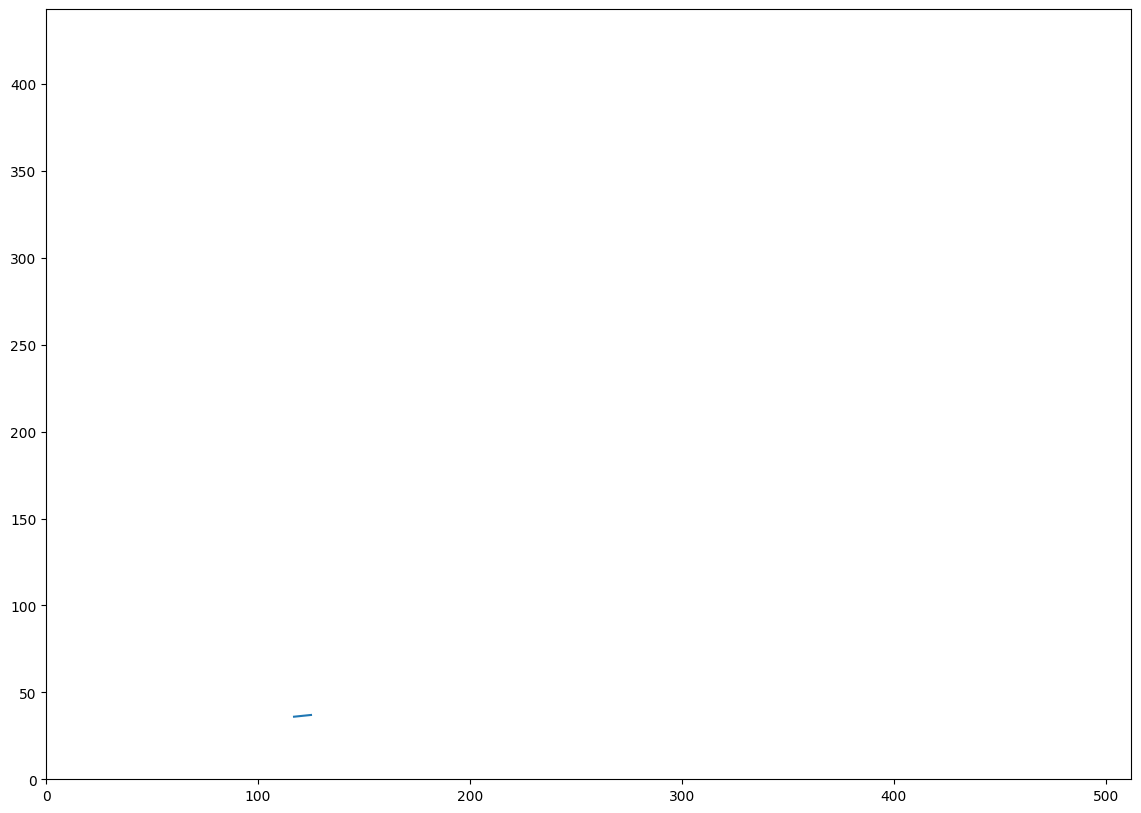

In [321]:
test = np.array(centroid_info)

startt = np.min(test[:,1, ...]);
endt = np.max(test[:,1,...]);

cell = 3

inds = np.where(test[:,0] == cell)

times = test[inds, 1]
xposits = test[inds,2]
yposits = test[inds,3]
#for i in range(startt, endt):

plt.plot(xposits[0], yposits[0])
plt.xlim([0,512])
plt.ylim([0,443])
plt.show()

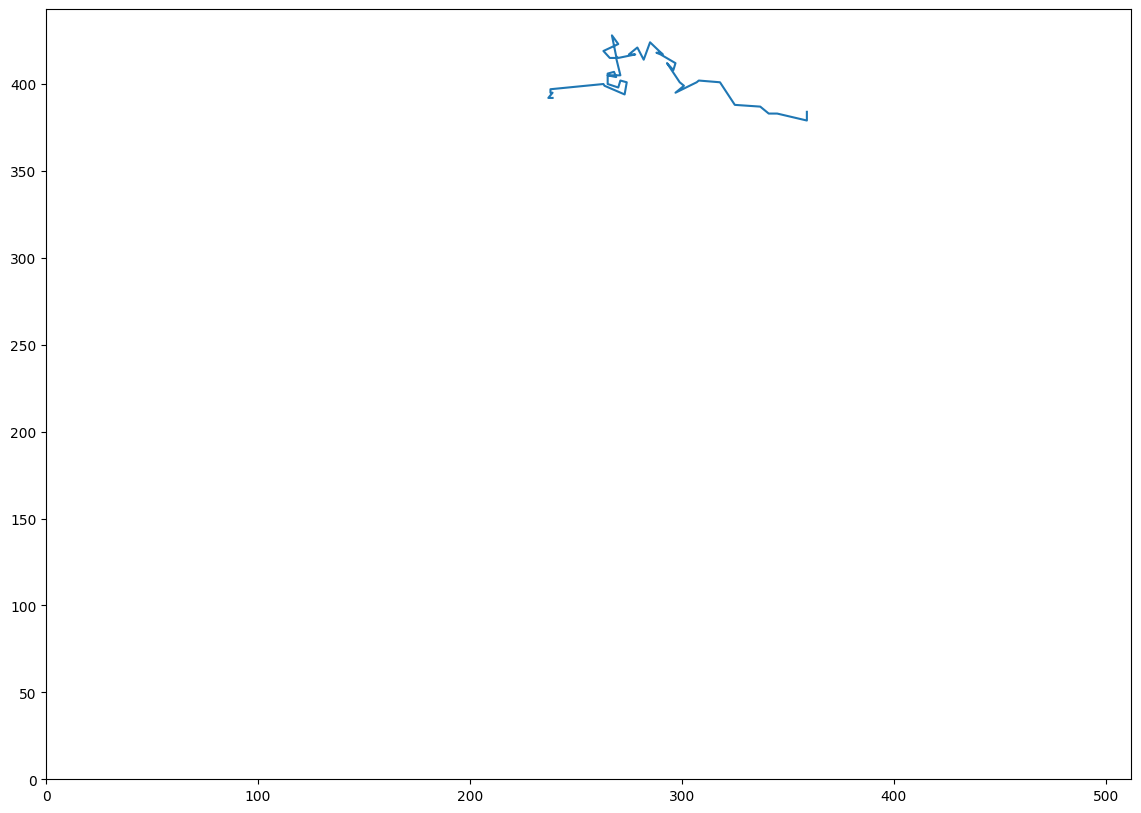

In [323]:
# x = np.where(bm_tracks[0,0, ...] == 1)
#plt.imshow(bm_tracks[0,0,x[0],x[1]])
# maybe = bm_tracks[np.where(bm_tracks[0,0,...] == 1)]
#blob = skimage.measure.regionprops(bm_tracks[bm_tracks[0,0,...] == 1])
cell = 10
cens = []

# for i in range(92):
#     blobs = skimage.measure.regionprops(bm_tracks[0,0])
#     isCell = False
#     for j in range(len(blobs)):
#         if(blobs[j].label == cell):
#             cens.append(blobs[j].centroid
#             isCell = True
#         else:
#              continue
    
#     if(isCell):
#         continue
#     else:
#         break
        
for i in range(92):
    blobs = skimage.measure.regionprops(bm_tracks[i,0])
    isCell = False
    for j in range(len(blobs)):
        if blobs[j].label == cell:
            cens.append(blobs[j].centroid)
            isCell = True
        continue
        
    if(isCell):
        continue
    else:
        break
        
cens = np.array(cens)
plt.plot(cens[:,0], cens[:, 1])
plt.xlim([0,512])
plt.ylim([0,443])
plt.show()

In [252]:
skimage.measure.regionprops(bm_tracks[0,0])[0].centroid

(55.0, 55.0)

In [309]:
cens[0]

(55.0, 55.0)

In [262]:
for blah in range(10):
    print('hell')

hell
hell
hell
hell
hell
hell
hell
hell
hell
hell
